<a href="https://colab.research.google.com/github/bipinsingh061/CSES/blob/main/Copy_of_ronylpatil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Normal
directory path : drive/MyDrive/coviddata2/archive/Dataset/Val/Normal
test
drive/MyDrive/coviddata2/archive/Dataset/Val/Normal/*.jpg
test
Covid
directory path : drive/MyDrive/coviddata2/archive/Dataset/Val/Covid
test
drive/MyDrive/coviddata2/archive/Dataset/Val/Covid/*.jpg
test
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
Covid
directory path : drive/MyDrive/coviddata2/archive/Dataset/Train/Covid
test
drive/MyDrive/coviddata2/archive/Dataset/Train/Covid/*.jpg
test
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works
the loop works


['xray.pkl']

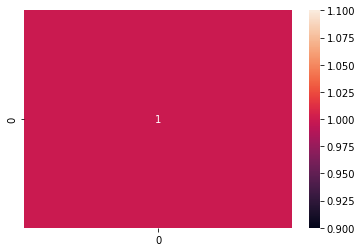

In [ ]:
# Architecture of Deep Hybrid Learning Model
"""
Project Name ->  Covid Detection using MRI's or CT Scan Images(Deep Hybrid Learning)
Project Description -> Here in this project I am combining best of the both world's, one is traditional Machine Learning and Deep Learning to create a 
                       solution that works amazing well specially when we have limited training dataset. Here I used VGG16 pretrained network for 
                       extracting usefull features of image dataset and finally used XGBOOST for classifying the images.
                       
                       XGBoost is optimized version of gradient boosting and it is a much evolved version of random forest, actually XGBoost optimize speed 
                       and possibly accuracy. Suppose we don't have millions or thousands of images that required for deep learning then I found 
                       that the accuracy that I got with tens of images with XGBoost is far superior to what we would get with deep learning. 
                       So anytime if we work with limited data, always think about XGBoost as first option and if it doesn't work great then of 
                       course try deep learning. I am sure that sometime deep learning will not be enough if we have limited data. We can also 
                       engineer our own feature extractor but here I'm going to use VGG16 pretrained architecture which make it easy for us to extract these 
                       features without defining alot of code.
                       
                       At the end these fusion trained 
                       on 1000 MRI's or CT scans images (500 each COVID-19 & NORMAL) and finally achieved 98.32% accuracy and it took only 21.89 seconds to 
                       train this model. This fusion learning reduce the training time of our model, in general deep larning
                       it usually takes a lot of time for training a model, but this hybrid technique reduced the training
                       time and at the same time gave very good accuracy.
Short Summary -> Image classification using XGBOOST by extracting features using VGG16 imagenet.
                 This project explain the process of using XGBOOST for image classification using pretrained weights (VGG16) as feature extractors.
        
Folder Structure ->  
                    X-ray       --> main folder
                    ----| train      
                        ----| COVID-19
                            ----| img1.jpg
                            ----| img2.jpg
                            ----| img3.jpg
                            ----| img4.jpg
                        ----| NORMAL
                            ----| img1.jpg
                            ----| img2.jpg
                            ----| img3.jpg
                            ----| img4.jpg
                    ----| test
                        ----| COVID-19
                            ----| img1.jpg
                            ----| img2.jpg
                            ----| img3.jpg
                            ----| img4.jpg
                        ----| NORMAL
                            ----| img1.jpg
                            ----| img2.jpg
                            ----| img3.jpg
                            ----| img4.jpg 
"""
# train dataset : E:\DHL Project\CNN Projects\Deep Hybrid Learning Projects\X-ray\train - 1000 units
# test dataset : E:\DHL Project\CNN Projects\Deep Hybrid Learning Projects\X-ray\test - 359 units

# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn import preprocessing
import joblib
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report


# Creating static and local variables
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 3
EPOCHS = 50
BATCH_SIZE = 16
input_shape = (SIZE, SIZE, CHANNELS)

#--------------------Training
def training(path) : 
    # loading data from local directory -> basic method. here labels are folder name, means each variety of data stored in particular folder.
    train_images = []       # training dataset stored here...(numpy array form of images)
    train_labels = []     # labels will be stored here 
    
    '''here we are using glob for accessing directories'''
    path = path + '/*'
    for directory_path in glob.glob(path) :   
        label = directory_path.split('/')[-1]       # taking labels from folders
        print(label)    # extracting label from directory path #n
        print("directory path : "+directory_path) #n
        '''now we are entering into each folder and reading images from it and at a same 
        time we are also storing the label.'''
        print("test")#n
        newpath=os.path.join(directory_path,'*.jpg') #n
        print(newpath) #n
        print("test") #n
        # for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) :
        for img_path in glob.glob(newpath) :    
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # read color image
            print("the loop works") #n
            img = cv2.merge((img, img, img))      # we have grey scale image, here we are converting it into 3 channel image
            img = cv2.resize(img, (SIZE, SIZE))        # resize the image
            
            '''actually cv2 read image in BGR channel ordering, in color image we have 3 channels
            RGB so here the channel order is different nothing special!. it doesnt affect on model.
            In reality we can arrange them in any order we like.'''
            # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            train_images.append(img)
            train_labels.append(label)
    
    # Shuffling the list to avoid the some kind of bias.
    train_data = list(zip(train_images, train_labels))
    '''Seed function is used to save the state of a random function, so that it can generate          
        same random numbers on multiple executions of the code on the same machine or on 
        different machines (for a specific seed value).'''
    random.seed(SEED_TRAINING)   
    random.shuffle(train_data)
    train_images, train_labels = zip(*train_data)   # it will unzip the ziped iterators, it will return tuple
    
    # converting tuples to numpy array.
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    # let's normalize our pixel values 
    train_images = train_images / 255.0
    return train_images, train_labels

def testing(path) : 
    test_images = []
    test_labels = []
    
    path = path + '\*'
    for directory_path in glob.glob(path) : 
        labels = directory_path.split('\\')[-1]
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) : 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.merge((img, img, img)) 
            img = cv2.resize(img, (SIZE, SIZE))
            test_images.append(img)
            test_labels.append(labels)
            
    # Shuffling testing data
    test_data = list(zip(test_images, test_labels))
    random.seed(SEED_TESTING)
    random.shuffle(test_data)
    test_images, test_labels = zip(*test_data)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # let's normalize our pixel values
    test_images = test_images / 255.0
    return test_images, test_labels

# preprocessing training and testing images
X_test, y_test_labels = training(r'drive/MyDrive/coviddata2/archive/Dataset/Val')
X_train, y_train_labels = training(r'drive/MyDrive/coviddata2/archive/Dataset/Train')

# encoding labels from text to integer
le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
train_label_encoded = le.transform(y_train_labels)
le.fit(y_test_labels)
test_label_encoded = le.transform(y_test_labels)

# extracting original labels, later we will need it.
labels = dict(zip(le.classes_,range(len(le.classes_))))
print(labels)

# aliasing for better understanding
y_train, y_test = train_label_encoded, test_label_encoded

# let's load VGG16 Architecture without fully connected layers, considerding only fully convolutional layers
vgg_model = VGG16(weights = 'imagenet',  include_top = False, input_shape = (SIZE, SIZE, 3)) 

# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False

# now trainable parameter will be 0 in our architecture
vgg_model.summary()

# let's extract features from convolutional network for XBG
feature_extractor = vgg_model.predict(X_train)

# actually our data in the form of (1000, 8, 8, 512) into (1000, 8*8*512) 
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

# perform same operation on test dataset
feature_extractor_test = vgg_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test

# defining XGBoost Classifier model
model = xgb.XGBClassifier()
model.fit(X_train_features, y_train)
prediction = model.predict(X_test_features)

# inversing le transforme to get original labels
prediction = le.inverse_transform(prediction)

# let's check overall accuracy
print('Accuracy : ', metrics.accuracy_score(y_test_labels, prediction))

# Confusion Matrics : Verify accuracy of each class
cm = confusion_matrix(y_test_labels, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

# Classification report
print(classification_report(y_test_labels, prediction))

# save the model
joblib.dump(model, 'xray.pkl')

# save model using pickle
# import pickle
# pickle.dump(model, open('modelp.pkl', 'wb'))